In [1]:

# Set up notebook
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import fu, nu
from datetime import date, timedelta
from pandas import DataFrame, to_datetime, Series
import numpy as np
import os
import os.path as osp
from IPython.display import HTML
import pandas as pd


# Analyze OW Patient Stats

In [3]:

# load data frames
data_frames_dict = nu.load_data_frames(
    verbose=False, metrics_evaluation_open_world_csv_stats_df='', metrics_evaluation_open_world_json_stats_df='',
    metrics_evaluation_open_world_scene_stats_df=''
)
logs_df = data_frames_dict['metrics_evaluation_open_world_csv_stats_df']
print(logs_df.shape) # (171766, 108)
json_stats_df = data_frames_dict['metrics_evaluation_open_world_json_stats_df']
print(json_stats_df.shape) # (43, 3570)
scene_stats_df = data_frames_dict['metrics_evaluation_open_world_scene_stats_df']
print(scene_stats_df.shape) # (76, 49)

(171766, 122)
(43, 3570)
(76, 50)


In [4]:

participant_columns = [
    'ST_Del_Text', 'AD_AttribGrp_Sim', 'Trust', 'ST_ConfFC_Text', 'Delegation', 'YrsMilExp', 'AD_Del_Text', 'MedExp', 'AD_AttribGrp_Text',
    'ST_ConfFC_Omni_Text', 'PropTrust', 'ST_KDMA_Text', 'AD_KDMA_Text', 'ST_AttribGrp_Text', 'ST_Del_Omni_Text', 'MilitaryExp',
    'AD_ConfFC_Omni_Text',
    'MedRole', 'ST_AttribGrp_Sim', 'AD_ConfFC_Text', 'ST_KDMA_Sim', 'AD_Del_Omni_Text', 'AD_KDMA_Sim'
]
needed_columns = [
    'scene_type', 'is_scene_aborted', 'is_a_one_triage_file', 'responder_category', 'responder_type', 'configData_scene',
    'configData_scenarioData_name', 'configData_scenarioData_description', 'encounter_layout', 'participantId', 'ParticipantID',
    'Sim1', 'Sim2'
] + participant_columns
anova_df = DataFrame([])


<h2>Here is my initial list but I am open to suggestions and modifications</h2>
<h3>IVs (these are not available in the csv; we are working on calculating them now and can get you that info.)</h3>
<ul>
    <li>Participant medical role</li>
    <li>Years of experience</li>
    <li>ST alignment score (continuous or group assignment)</li>
    <li>AD alignment score (continuous or group assignment)</li>
</ul>
<h3>DVs</h3>
<ul>
    <li>Total number of actions</li>
    <li>Count of assessment actions</li>
    <li>Count of treatment actions</li>
    <li>Count of tags applied</li>
    <li>Order of patients engaged</li>
    <li>Tag color for each patient</li>
    <li>Treat expectant patient (yes/no)</li>
    <li>Triage efficiency</li>
    <li>Time to hemorrhage control</li>
</ul>

In [6]:

# Get all patient stats
from numpy import nan

if nu.pickle_exists('metrics_evaluation_open_world_patient_stats_df'):
    patient_stats_df = nu.load_object('metrics_evaluation_open_world_patient_stats_df')
else:
    rows_list = []
    for (session_uuid, scene_id), scene_df in elevens_df.groupby(fu.scene_groupby_columns):
        scene_start = fu.get_scene_start(scene_df)
        for (encounter_layout, patient_id), patient_df in scene_df.groupby(['encounter_layout', 'patient_id']):
            row_dict = {cn: eval(cn) for cn in ['encounter_layout'] + fu.patient_groupby_columns}
            
            # Get all the FRVRS utils scalar patient values
            row_dict['first_patient_interaction'] = fu.get_first_patient_interaction(patient_df)
            row_dict['first_patient_triage'] = fu.get_first_patient_triage(patient_df)
            row_dict['is_correct_bleeding_tool_applied'] = fu.get_is_correct_bleeding_tool_applied(patient_df)
            row_dict['is_patient_dead'] = fu.get_is_patient_dead(patient_df)
            row_dict['is_patient_gazed_at'] = fu.get_is_patient_gazed_at(patient_df)
            row_dict['is_patient_severely_hemorrhaging'] = fu.get_is_patient_severely_hemorrhaging(patient_df)
            row_dict['is_patient_still'] = fu.get_is_patient_still(patient_df)
            row_dict['is_tag_correct'] = fu.get_is_tag_correct(patient_df)
            row_dict['last_patient_interaction'] = fu.get_last_patient_interaction(patient_df)
            row_dict['last_tag'] = fu.get_last_tag(patient_df)
            row_dict['max_salt'] = fu.get_max_salt(patient_df, session_uuid=session_uuid, scene_id=scene_id, random_patient_id=patient_id)
            row_dict['maximum_injury_severity'] = fu.get_maximum_injury_severity(patient_df)
            row_dict['patient_engagement_count'] = fu.get_patient_engagement_count(patient_df)
            row_dict['pulse_value'] = fu.get_pulse_value(patient_df)
            row_dict['tag_value'] = fu.get_tag_value(patient_df)
            row_dict['time_to_hemorrhage_control'] = fu.get_time_to_hemorrhage_control(patient_df, scene_start)
            mask_series = ~patient_df.injury_id.isnull()
            if mask_series.any():
                injury_id = patient_df[mask_series].injury_id.iloc[-1]
                row_dict['treatment_value'] = fu.get_treatment_value(patient_df, injury_id)
            row_dict['wrapped_label'] = fu.get_wrapped_label(patient_df)
            
            mask_series = ~patient_df.tag_applied_type.isnull()
            tag_applied_type_count = patient_df[mask_series].tag_applied_type.unique().shape[0]
            mask_series = ~patient_df.patient_record_salt.isnull()
            patient_record_salt_count = patient_df[mask_series].patient_record_salt.unique().shape[0]
            if (tag_applied_type_count > 0) and (patient_record_salt_count > 0): row_dict['tag_correct'] = fu.get_is_tag_correct(patient_df)
            else: row_dict['tag_correct'] = nan
            
            mask_series = patient_df.action_type.isin(fu.action_types_list)
            row_dict['action_count'] = patient_df[mask_series].shape[0]
            
            mask_series = patient_df.action_type.isin(['PATIENT_ENGAGED', 'PULSE_TAKEN'])
            row_dict['assessment_count'] = patient_df[mask_series].shape[0]
            
            mask_series = patient_df.action_type.isin(['INJURY_TREATED'])
            row_dict['treatment_count'] = patient_df[mask_series].shape[0]
            
            mask_series = patient_df.action_type.isin(['TAG_APPLIED'])
            row_dict['tag_application_count'] = patient_df[mask_series].shape[0]
            
            if (row_dict['max_salt'] == 'EXPECTANT'):
                mask_series = ~patient_df.injury_treated_required_procedure.isnull() | ~patient_df.tool_applied_type.isnull()
                row_dict['treated_expectant'] = {True: 'yes', False: 'no'}[mask_series.any()]
            else: row_dict['treated_expectant'] = nan
            
            rows_list.append(row_dict)
    patient_stats_df = DataFrame(rows_list)
    patient_stats_df.max_salt = patient_stats_df.max_salt.astype(fu.salt_category_order)
    patient_stats_df.last_tag = patient_stats_df.last_tag.astype(fu.colors_category_order)
    
    # Save so you don't have to run it again
    nu.store_objects(metrics_evaluation_open_world_patient_stats_df=patient_stats_df)
    nu.save_data_frames(metrics_evaluation_open_world_patient_stats_df=patient_stats_df)
print(patient_stats_df.shape) # (334, 28)

(334, 28)


In [13]:

column_descriptions_df = nu.get_column_descriptions(patient_stats_df)
mask_series = (column_descriptions_df.min_value == False) & (column_descriptions_df.max_value == True)
mask_series &= (column_descriptions_df.dtype == 'object')
for cn in column_descriptions_df[mask_series].column_name: patient_stats_df[cn] = patient_stats_df[cn].astype(bool)
nu.store_objects(metrics_evaluation_open_world_patient_stats_df=patient_stats_df)
nu.save_data_frames(metrics_evaluation_open_world_patient_stats_df=patient_stats_df)

Pickling to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/metrics_evaluation_open_world_patient_stats_df.pkl
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_patient_stats_df.csv


In [14]:

column_descriptions_df = nu.get_column_descriptions(patient_stats_df)
display(column_descriptions_df)
mask_series = (column_descriptions_df.dtype == 'int64')
print()
for cn in column_descriptions_df[mask_series].column_name:
    print(f"""            row_dict['max_{cn}'] = scene_df.{cn}.max()""")

,column_name,dtype,count_blanks,count_uniques,count_zeroes,has_dates,min_value,max_value,only_integers
0,is_correct_bleeding_tool_applied,bool,0,1,334,False,False,False,True
1,is_patient_dead,bool,0,2,260,False,False,True,True
2,is_patient_gazed_at,bool,0,2,238,False,False,True,True
3,is_patient_severely_hemorrhaging,bool,0,2,286,False,False,True,True
4,is_patient_still,bool,0,2,169,False,False,True,True
5,is_tag_correct,bool,0,2,111,False,False,True,True
6,tag_correct,bool,0,2,111,False,False,True,True
7,last_tag,category,228,3,0,False,gray,red,NaN
8,max_salt,category,334,1,0,False,NaN,NaN,NaN
9,first_patient_interaction,float64,99,236,0,True,16844.0,955024.0,False



            row_dict['max_scene_id'] = scene_df.scene_id.max()
            row_dict['max_patient_engagement_count'] = scene_df.patient_engagement_count.max()
            row_dict['max_pulse_value'] = scene_df.pulse_value.max()
            row_dict['max_tag_value'] = scene_df.tag_value.max()
            row_dict['max_time_to_hemorrhage_control'] = scene_df.time_to_hemorrhage_control.max()
            row_dict['max_action_count'] = scene_df.action_count.max()
            row_dict['max_assessment_count'] = scene_df.assessment_count.max()
            row_dict['max_treatment_count'] = scene_df.treatment_count.max()
            row_dict['max_tag_application_count'] = scene_df.tag_application_count.max()


In [18]:

def is_numeric(value):
    try:
        float(value)
        return not pd.isna(value)
    except ValueError: pass
    except TypeError: return False
    try:
        int(value)
        return True
    except ValueError: return False
numeric_columns = []
for cn in patient_stats_df.dropna(axis='columns', how='all').columns:
    if patient_stats_df[cn].map(lambda x: is_numeric(x)).all(): numeric_columns.append(cn)
mask_series = column_descriptions_df.column_name.isin(numeric_columns) | (column_descriptions_df.dtype == 'float64')
numeric_columns = patient_stats_df[column_descriptions_df[mask_series].column_name].dropna(axis='columns', how='all').columns
display(numeric_columns)

Index(['is_correct_bleeding_tool_applied', 'is_patient_dead',
       'is_patient_gazed_at', 'is_patient_severely_hemorrhaging',
       'is_patient_still', 'is_tag_correct', 'tag_correct',
       'first_patient_interaction', 'first_patient_triage',
       'last_patient_interaction', 'treatment_value', 'scene_id',
       'patient_engagement_count', 'pulse_value', 'tag_value',
       'time_to_hemorrhage_control', 'action_count', 'assessment_count',
       'treatment_count', 'tag_application_count'],
      dtype='object')

In [ ]:

# Remove the Unity suffix from all patient_id columns
# The one without "Root" is the ID CACI sets for it. Unity
# then takes the ID and adds "Root" to the end when it
# creates the hierarchy, so there's less room for human
# error. They're going to match perfectly.
for cn in fu.patient_id_columns_list + ['patient_id']:
    if cn in patient_stats_df.columns:
        mask_series = ~patient_stats_df[cn].isnull()
        patient_stats_df.loc[mask_series, cn] = patient_stats_df[mask_series][cn].map(lambda x: str(x).replace(' Root', ''))

In [ ]:

for cn in numeric_columns:
    mask_series = patient_stats_df.patient_id.isin(
        fu.desert_patients_list + fu.jungle_patients_list + fu.submarine_patients_list + fu.urban_patients_list
    )
    mask_series &= ~patient_stats_df[cn].isnull()
    if mask_series.any():
        transformable_df = patient_stats_df[mask_series].groupby(fu.scene_groupby_columns).min().reset_index(drop=False).sort_values(cn)
        fu.plot_grouped_box_and_whiskers(
            transformable_df,
            'patient_id',
            cn,
            'Patient ID',
            ' '.join([w.title() for w in cn.split('_')]),
            transformer_name=None,
            is_y_temporal=False,
        )

In [8]:

# Add file and scene columns to the 11-patient scenes
participant_columns = [
    'ST_Del_Text', 'AD_AttribGrp_Sim', 'Trust', 'ST_ConfFC_Text', 'Delegation', 'YrsMilExp', 'AD_Del_Text', 'MedExp', 'AD_AttribGrp_Text',
    'ST_ConfFC_Omni_Text', 'PropTrust', 'ST_KDMA_Text', 'AD_KDMA_Text', 'ST_AttribGrp_Text', 'ST_Del_Omni_Text', 'MilitaryExp',
    'AD_ConfFC_Omni_Text',
    'MedRole', 'ST_AttribGrp_Sim', 'AD_ConfFC_Text', 'ST_KDMA_Sim', 'AD_Del_Omni_Text', 'AD_KDMA_Sim'
]
needed_columns = [
    'scene_type', 'is_scene_aborted', 'is_a_one_triage_file', 'responder_category', 'responder_type', 'configData_scene',
    'configData_scenarioData_name', 'configData_scenarioData_description', 'encounter_layout', 'participantId', 'ParticipantID',
    'Sim1', 'Sim2'
] + participant_columns
elevens_df = fu.get_elevens_data_frame(
    logs_df, json_stats_df, scene_stats_df, needed_columns=needed_columns
)
print(elevens_df.shape) # (65370, 143)

(65370, 143)


In [ ]:

# Create the tag-to-SALT data frame
tag_to_salt_df = fu.get_is_tag_correct_data_frame(elevens_df, groupby_column='encounter_layout')

In [ ]:

# Get the percentage tag correct counts for each scene for each group
correct_count_by_tag_df = fu.get_percentage_tag_correct_data_frame(tag_to_salt_df, groupby_column='encounter_layout')


----
# ANOVA Analysis

In [ ]:

for participant_id in range(2_024_201, 2_024_223+1):
    ldf = logs_df[logs_df.participant_id == participant_id]
    fsdf = json_stats_df[json_stats_df.participant_id == participant_id]
    ssdf = scene_stats_df[scene_stats_df.participant_id == participant_id]
    on_columns = sorted(set(ldf.columns).intersection(set(fsdf.columns)))
    participant_elevens_df = ldf.merge(fsdf, on=on_columns)
    on_columns = sorted(set(participant_elevens_df.columns).intersection(set(ssdf.columns)))
    participant_elevens_df = participant_elevens_df.merge(ssdf, on=on_columns)
    # print(participant_id, ldf.shape[0], fsdf.shape[0], ssdf.shape[0], participant_elevens_df.shape[0], sep='\t'); continue
    if participant_elevens_df.shape[0]:
        
        # Set priority group column
        mask_series = participant_elevens_df.patient_id.isin(priority_group_dict.keys())
        if mask_series.any():
            participant_elevens_df.loc[mask_series, 'priority_group'] = participant_elevens_df.loc[mask_series, 'patient_id'].map(
                priority_group_dict
            )
        
        # Get patient sort dictionary
        mask_series = ~participant_elevens_df.patient_sort.isnull()
        patient_sort_dict = participant_elevens_df[mask_series].set_index('patient_id').patient_sort.to_dict()
        print(patient_sort_dict); raise
        
        # Set patient sort column
        mask_series = participant_elevens_df.patient_id.isin(patient_sort_dict.keys())
        if mask_series.any():
            participant_elevens_df.loc[mask_series, 'patient_sort'] = participant_elevens_df.loc[mask_series, 'patient_id'].map(
                patient_sort_dict
            )
        
        # Get the patient stats
        participant_patient_stats_df = fu.get_patient_stats_data_frame(participant_elevens_df)
        
        # Create the tag-to-SALT data frame
        tag_to_salt_df = fu.get_is_tag_correct_data_frame(participant_elevens_df, groupby_column='encounter_layout')
        
        # Get the percentage tag correct counts for each scene for each group
        correct_count_by_tag_df = fu.get_percentage_tag_correct_data_frame(tag_to_salt_df, groupby_column='encounter_layout')
        
        # Create the ANOVA data frame
        rows_list = []
        for encounter_layout, encounter_layout_df in participant_patient_stats_df.groupby('encounter_layout'):
            patients_list = eval(f'{encounter_layout.lower()}_patients_list')
            for (session_uuid, scene_id), scene_df in encounter_layout_df.groupby(fu.scene_groupby_columns):
                mask_series = scene_df.patient_id.isin(patients_list)
                if mask_series.any():
                    # scene_start = fu.get_scene_start(scene_df)
                    row_dict = {
                        'participant_id': participant_id, 'Environment': encounter_layout, 'session_uuid': session_uuid, 'scene_id': scene_id
                    }
                    for cn in participant_columns: row_dict[cn] = participant_elevens_df[cn].mean()
                    for cn in ['priority_group', 'patient_sort']:
                        if cn in scene_df.columns: row_dict[f'swaps_to_perfect_{cn}_order_count'] = eval(
                            f'scene_df.swaps_to_perfect_{cn}_order_count.mean()'
                        )
        
                    # Get the start of the whole scene
                    scene_mask_series = True
                    for cn in fu.scene_groupby_columns: scene_mask_series &= (participant_elevens_df[cn] == eval(cn))
                    scene_start = fu.get_scene_start(participant_elevens_df[scene_mask_series])
                    
                    row_dict['mean_first_patient_interaction'] = scene_df.first_patient_interaction.map(lambda x: x - scene_start).mean()
                    row_dict['mean_last_patient_interaction'] = scene_df.last_patient_interaction.map(lambda x: x - scene_start).mean()
                    row_dict['total_patient_engagement_count'] = scene_df.patient_engagement_count.sum()
                    row_dict['total_action_count'] = scene_df.action_count.sum()
                    row_dict['total_assessment_count'] = scene_df.assessment_count.sum()
                    row_dict['total_treatment_count'] = scene_df.treatment_count.sum()
                    row_dict['total_tag_application_count'] = scene_df.tag_application_count.sum()
                    row_dict['max_time_to_hemorrhage_control'] = scene_df.time_to_hemorrhage_control.max() - scene_start
        
                    mask_series = (scene_df.treated_expectant == 'yes')
                    row_dict['treated_expectant'] = mask_series.any()
        
                    # Get the whole scene history
                    scene_df = participant_elevens_df[scene_mask_series]
                    mask_series = scene_df.patient_id.isin(patients_list)
                    
                    row_dict['triage_time'] = fu.get_triage_time(scene_df[mask_series])
                    row_dict['time_to_last_hemorrhage_controlled'] = fu.get_time_to_last_hemorrhage_controlled(scene_df[mask_series])
                    
                    # Duration of time from when the patient was first approached by the participant until
                    # the time hemorrhage treatment was applied (with a tourniquet or wound packing)
                    row_dict['time_to_hemorrhage_control_per_patient'] = fu.get_time_to_hemorrhage_control_per_patient(scene_df)
                    
                    mask_series = (correct_count_by_tag_df.session_uuid == session_uuid) & (correct_count_by_tag_df.scene_id == scene_id)
                    if mask_series.any():
                        row_dict['mean_percentage_tag_correct'] = correct_count_by_tag_df[mask_series].percentage_tag_correct.mean()
                    
                    rows_list.append(row_dict)
        participant_anova_df = DataFrame(rows_list)
        
        # Append the data frame for the current participant to the main data frame
        anova_df = pd.concat([anova_df, participant_anova_df], axis='index')

In [9]:

def plot_quantiles_and_histogram(theoretical_quantiles, cn_data, xname, anova_with_dummies_df, cn):
    
    # Create a figure and subplots with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Create the QQ Plot
    ax1.scatter(theoretical_quantiles, cn_data)
    ax1.set_xlabel('Standard Normal Quantiles')
    ax1.set_ylabel(f'{xname} Values')
    ax1.set_title(f'QQ Plot of {xname}')
    ax1.grid(True)
    
    # Create the Histogram
    ax2 = nu.plot_histogram(
        anova_with_dummies_df, cn, xname, f'{xname} Histogram', xtick_text_fn=None, ylabel=None, xticks_are_temporal=False, ax=ax2,
        color=None, bins=100
    )
    
    # Humanize y tick labels
    yticklabels_list = []
    for text_obj in ax2.get_yticklabels():
        position_tuple = text_obj.get_position()
        text_obj.set_text(int(position_tuple[1]))
        yticklabels_list.append(text_obj)
    if (len(yticklabels_list) > 17): ax2.set_yticklabels(yticklabels_list, rotation=90)
    else: ax2.set_yticklabels(yticklabels_list)
    
    # Adjust layout (optional)
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    
    return plt

In [10]:

def append_regression_equation(statements_list, columns_list, dataset_organization_df, groupby_column, results):
    statements_list.append("Regression Equation:")
    format_str = "{} = {:.4f} + " + ' + '.join([f'{{:.4f}} * {cn}' for cn in columns_list])
    mask_series = (dataset_organization_df.Variable == groupby_column.replace('_Text', ''))
    if mask_series.any():
        equation_dict = {}
        for kv in dataset_organization_df[mask_series].Labels:
            kv_split = re.split(' *= *', kv, 0)
            if len(kv_split) == 2: equation_dict[float(kv_split[0])] = re.sub('[^A-Za-z0-9]+', '_', kv_split[1]).strip('_')
        for k, v in equation_dict.items(): format_str = format_str.replace('_' + str(k), '_' + v)
    statements_list.append(format_str.format(
        groupby_column, results.params['const'], *[results.params[cn] for cn in columns_list]
    ))

    return True, statements_list

In [11]:

def compare_the_pairs(anova_with_dummies_df, groupby_column, grouped_data, statements_list, cn_data):
    transformable_df = DataFrame([])
    display_box_and_whiskers = False
    
    # Compare the pairs
    mask_series = ~anova_with_dummies_df[groupby_column].isnull()
    for pair in itertools.combinations(anova_with_dummies_df[mask_series][groupby_column].unique(), 2):
        env1 = pair[0]; env2 = pair[1]
        env1_data = grouped_data.get_group(env1)[cn]
        env2_data = grouped_data.get_group(env2)[cn]
        t_statistic, p_value = ttest_ind(env1_data, env2_data)
        if p_value < 0.05: statements_list.append(f"    t-test between {env1} and {env2}: t = {t_statistic:.4f}, p = {p_value:.4f}")
    
    # Display a box and whiskers plot
    mask_series = ~cn_data.isnull()
    if mask_series.any():
        transformable_df = anova_with_dummies_df[mask_series]
        display_box_and_whiskers = True

    return transformable_df, display_box_and_whiskers, statements_list

In [12]:

def calculate_epsilon_squared(anova_with_dummies_df, groupby_column, kruskal_results, cn, data_by_env, cn_data):
    
    # Epsilon squared (effect size)
    n = len(anova_with_dummies_df)  # Total number of observations
    k = len(anova_with_dummies_df[groupby_column].unique())  # Number of groups
    
    # Calculate manually
    try:
        ss_between = kruskal_results.statistic * n / (k * (k - 1))
        ss_total = kruskal_results.ss  # Access total sum of squares from results
        epsilon_squared = ss_between / ss_total
    
    # Alternative way to calculate sum of squares within groups (SSwithin)
    except:
        ss_within = sum([group[cn].var(ddof=0) * len(group) for name, group in data_by_env])
        
        # Total sum of squares (SStotal) - using variance of entire data
        ss_total = cn_data.var(ddof=0) * len(anova_with_dummies_df)
        
        # Epsilon squared calculation
        epsilon_squared = (kruskal_results.statistic * n) / (k * (k - 1) * ss_within / ss_total)

    return epsilon_squared

In [13]:

def perform_kruskal_wallis(statements_list, grouped_data, anova_with_dummies_df, groupby_column, cn, cn_data):
    
    # Perform Kruskal-Wallis test on values
    kruskal_statistic, p_value = kruskal(*[group[cn] for name, group in grouped_data])
    
    # Access additional test details from the result object
    kruskal_results = kruskal(*[group[cn] for name, group in grouped_data])
    
    # Extract chi-squared statistic (equivalent to H statistic)
    chi_squared = kruskal_results.statistic
    
    # Degrees of freedom (number of groups - 1)
    degrees_of_freedom = len(anova_with_dummies_df[groupby_column].unique()) - 1
    
    # Append the complete results
    statements_list.append(f"Kruskal-Wallis test for {cn}: H statistic = {kruskal_statistic:.4f}, p-value = {p_value:.4f}")
    statements_list.append(f"    χ² = {chi_squared:.4f}, df = {degrees_of_freedom}, p-value = {p_value:.4f}")

    # Epsilon squared calculation
    epsilon_squared = calculate_epsilon_squared(anova_with_dummies_df, groupby_column, kruskal_results, cn, grouped_data, cn_data)

    # Append the results
    if not pd.isna(epsilon_squared): statements_list.append(f"    ε² (effect size) = {epsilon_squared:.4f}")

    return statements_list, p_value

In [14]:

def perform_anova(statements_list, grouped_data, cn_data, cn):
    
    # Perform ANOVA on values to get F statistic and p-value
    f_statistic, p_value = f_oneway(*[group[cn] for name, group in grouped_data])
    
    # Append the results
    if not pd.isna(p_value): statements_list.append(f"One-way ANOVA for {cn}: F statistic = {f_statistic:.4f}, p-value = {p_value:.4f}")

    # Calculate the sum of squares between groups (SS_between)
    mean_overall = cn_data.mean()  # Mean of all values
    SS_between = sum(len(group) * (group[cn].mean() - mean_overall)**2 for name, group in grouped_data)
    
    # Calculate the total sum of squares (SS_total)
    SS_total = sum((value - mean_overall)**2 for name, group in grouped_data for value in group[cn])
    
    # Compute eta-squared (η²) and append the results
    try: eta_squared = SS_between / SS_total
    except: eta_squared = np.nan
    if not pd.isna(eta_squared): statements_list.append(f"    η² (effect size) = {eta_squared:.4f}")
    
    # Generate theoretical quantiles from a standard normal distribution
    theoretical_quantiles = norm.ppf(cn_data.rank() / (len(cn_data) + 1))

    return statements_list, theoretical_quantiles, True, p_value

In [15]:

def compare_groups(statements_list, p_value, grouped_data, cn_data, cn, anova_with_dummies_df, groupby_column):
    theoretical_quantiles = None; display_qq_plot = False; transformable_df = DataFrame([]); display_box_and_whiskers = False
    
    # Fail to reject the null hypothesis of normality
    if (p_value >= 0.05): statements_list, theoretical_quantiles, display_qq_plot, p_value = perform_anova(
        statements_list, grouped_data, cn_data, cn
    )

    # The data does not come from a normal distribution: consider non-parametric tests
    else: statements_list, p_value = perform_kruskal_wallis(statements_list, grouped_data, anova_with_dummies_df, groupby_column, cn, cn_data)
    
    # Test shows a significant difference (p-value < 0.05)
    if p_value < 0.05: transformable_df, display_box_and_whiskers, statements_list = compare_the_pairs(
        anova_with_dummies_df, groupby_column, grouped_data, statements_list, cn_data
    )

    return statements_list, theoretical_quantiles, display_qq_plot, transformable_df, display_box_and_whiskers

In [16]:

def perform_shapiro_francia(cn_data, statements_list):
    from scipy.stats import shapiro
    
    # Perform Shapiro-Francia test
    stat, p_value = shapiro(cn_data)
    
    # Append the test results
    if not pd.isna(stat): statements_list.append(f'Shapiro-Francia Test for normality ({cn}): Statistic: {stat:.4f}, p-value: {p_value:.4f}')

    return statements_list, p_value

In [17]:

def perform_shapiro_wilk(cn_data, statements_list):
    from scipy.stats import shapiro_wilk
    
    # Perform Shapiro-Wilk test
    stat, p_value = shapiro_wilk(cn_data)
    
    # Append the test results
    if not pd.isna(stat): statements_list.append(f'Shapiro-Wilk Test for normality ({cn}): Statistic: {stat:.4f}, p-value: {p_value:.4f}')

    return statements_list, p_value

In [34]:

def perform_linear_regression(
    cn, xname, description_dict, groupby_column, grouped_data, anova_with_dummies_df, dataset_organization_df, file_path, save_only=False
):
    statements_list = []; display_box_and_whiskers = False; display_qq_plot = False; display_regression_equation = False
    cn_data = anova_with_dummies_df[cn]
    # statements_list.append(f"\n{xname}{description_dict.get(cn, '')} grouped by {groupby_column}{description_dict.get(groupby_column, '')}")
    statements_list.append(f"\n{xname} ({entitle_column_name(xname)}) grouped by {groupby_column} ({entitle_column_name(groupby_column)})")
    
    # Perform a test for normality
    try: statements_list, p_value = perform_shapiro_wilk(cn_data, statements_list)
    except: statements_list, p_value = perform_shapiro_francia(cn_data, statements_list)

    if grouped_data.ngroups > 1:
        statements_list, theoretical_quantiles, display_qq_plot, transformable_df, display_box_and_whiskers = compare_groups(
            statements_list, p_value, grouped_data, cn_data, cn, anova_with_dummies_df, groupby_column
        )
    
    # Perform linear regression
    columns_list = [cn for cn in anova_with_dummies_df.columns if cn.startswith(f'{groupby_column}_')]
    results = sm.OLS(cn_data, anova_with_dummies_df[['const'] + columns_list]).fit()
    
    # Append the regression equation
    if not pd.isna(results.params['const']): display_regression_equation, statements_list = append_regression_equation(
        statements_list, columns_list, dataset_organization_df, groupby_column, results
    )
    
    with open(file_path, mode='a', encoding=nu.encoding_type) as f: print('\n'.join(statements_list), file=f)
    if display_regression_equation and (cn in participant_columns):
        if display_qq_plot:
            plt = plot_quantiles_and_histogram(theoretical_quantiles, cn_data, xname, anova_with_dummies_df, cn)
            
            # Save the figure to PNG
            if save_only:
                plt.savefig(f'../saves/png/quantiles_and_histogram_{xname}_{cn}.png', bbox_inches='tight')
                plt.ion()
        
        if display_box_and_whiskers:
            plt = fu.plot_grouped_box_and_whiskers(
                transformable_df, groupby_column, cn, groupby_column, ' '.join([w.title() for w in cn.split('_')]),
                transformer_name=None, is_y_temporal=False
            )
            
            # Save the figure to PNG
            if save_only:
                plt.savefig(f'../saves/png/grouped_box_and_whiskers_{groupby_column}_{cn}.png', bbox_inches='tight')
                plt.ion()

In [35]:

def compare_columns(anova_df, groupby_column, columns_set, description_dict, dataset_organization_df, file_path):
    
    # Encode the group-by column into dummy variables
    dummy_groupby = pd.get_dummies(anova_df[groupby_column], prefix=groupby_column)
    
    # Concatenate the dummy variables with the dataframe
    anova_with_dummies_df = pd.concat([anova_df, dummy_groupby], axis=1)
    
    # Add a constant term to the independent variables
    anova_with_dummies_df['const'] = 1
    
    # Group data by groupby columns
    grouped_data = anova_with_dummies_df.groupby(groupby_column)
    
    for cn in set(columns_set).difference(set([groupby_column])): perform_linear_regression(
        cn, ' '.join([w.title() for w in cn.split('_')]), description_dict, groupby_column, grouped_data, anova_with_dummies_df,
        dataset_organization_df,
        file_path, save_only=True
    )

In [36]:

# Attempt to manufacture some better column names
from pandas import read_excel

dataset_organization_df = read_excel('../data/xlsx/Metrics_Evaluation_Dataset_organization_for_BBAI.xlsx')

mask_series = ~dataset_organization_df.Description.isnull()#re.sub('[^A-Za-z0-9]+', '_', x)
df = dataset_organization_df[mask_series]
description_dict = df.set_index('Variable').Description.map(lambda x: ' (' + x + ')').to_dict()
new_description_dict = description_dict.copy()
for k, v in description_dict.items():
    new_description_dict[k] = v
    new_description_dict[f'{k}_Text'] = v
description_dict = new_description_dict.copy()

In [37]:

# Which factors contribute to the variance in these outcomes?
# Set up a regression equation (it will be continuous between 0 and 1) as the outcome
from scipy.stats import f_oneway, ttest_ind
import itertools
from scipy.stats import kruskal
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.api as sm
import re

# Get the numeric columns
numeric_columns = nu.get_numeric_columns(anova_df)

file_path = osp.join(nu.saves_text_folder, 'contributing_factors.txt')
with open(file_path, mode='w', encoding=nu.encoding_type) as f: print('', file=f)
columns_set = set(numeric_columns).difference(set(['scene_id', 'participant_id'] + participant_columns))
for groupby_column in participant_columns:
    compare_columns(anova_df, groupby_column, columns_set, description_dict, dataset_organization_df, file_path)

In [ ]:

print()
for groupby_column in participant_columns:
    for cn in set(columns_set).difference(set([groupby_column])):
        print(f"Does {cn} contribute to the variance in {groupby_column}?")


We present basic summary statistics (descriptive statistics) for each independent variable (IV) and dependent variable (DV) to understand the data distribution. 

In [46]:

print()
df = nu.get_statistics(anova_df, columns_set)
temporalize_fn = lambda x: fu.format_timedelta(timedelta(milliseconds=int(x)), minimum_unit='minutes')
time_columns = [
    'mean_first_patient_interaction', 'max_time_to_hemorrhage_control', 'triage_time', 'time_to_last_hemorrhage_controlled',
    'time_to_hemorrhage_control_per_patient', 'mean_last_patient_interaction'
]
for cn in columns_set.difference(set(['participant_id'])):
    descr_str = description_dict.get(cn, '')
    if descr_str: print_str = f'{cn}{descr_str}'
    else: print_str = f'{cn}'
    stats_dict = df.to_dict()[cn]
    if cn in time_columns: print(
        f"{print_str}: {temporalize_fn(stats_dict['mean'])} (SD = {temporalize_fn(stats_dict['SD'])},"
        f" Median = {temporalize_fn(stats_dict['median'])})"
    )
    else: print(f"{print_str}: {stats_dict['mean']:,.02f} (SD = {stats_dict['SD']:,.02f}, Median = {stats_dict['median']:,.02f})")


total_assessment_count: 42.90 (SD = 23.63, Median = 44.00)
MedExp (Level of agreement to being a “Seasoned first responder”): 0.55 (SD = 0.83, Median = 0.00)
AD_KDMA_Sim (KDMA measurement from simulator probe responses): 0.44 (SD = 0.13, Median = 0.47)
ST_ConfFC_Omni_Text (Confidence rating in forced choice delegation response; higher numbers is higher confidence; omnibus DMs): 2.90 (SD = 0.82, Median = 3.00)
total_tag_application_count: 7.29 (SD = 3.24, Median = 8.00)
ST_ConfFC_Text (Confidence rating in forced choice delegation response; higher numbers is higher confidence; individual scenario DMs): 2.61 (SD = 0.57, Median = 2.50)
AD_ConfFC_Text (Confidence rating in forced choice delegation response; higher numbers is higher confidence; individual scenario DMs): 2.23 (SD = 0.71, Median = 2.50)
AD_Del_Text (Overall rate of delegation on AD scenarios when given delegation choice between 2 DMs, either, or neither; individual scenario DMs): 0.81 (SD = 0.31, Median = 1.00)
total_treatme

In [14]:

# Create the ANOVA data frame
rows_list = []
for encounter_layout, encounter_layout_df in patient_stats_df.groupby('encounter_layout'):
    patients_list = eval(f'{encounter_layout.lower()}_patients_list')
    for (session_uuid, scene_id), scene_df in encounter_layout_df.groupby(fu.scene_groupby_columns):
        mask_series = scene_df.patient_id.isin(patients_list)
        if mask_series.any():
            # scene_start = fu.get_scene_start(scene_df)
            row_dict = {'Environment': encounter_layout, 'session_uuid': session_uuid, 'scene_id': scene_id}

            # Get the start of the whole scene
            scene_mask_series = True
            for cn in fu.scene_groupby_columns: scene_mask_series &= (elevens_df[cn] == eval(cn))
            scene_start = fu.get_scene_start(elevens_df[scene_mask_series])
            
            row_dict['mean_first_patient_interaction'] = scene_df.first_patient_interaction.map(lambda x: x - scene_start).mean()
            row_dict['mean_last_patient_interaction'] = scene_df.last_patient_interaction.map(lambda x: x - scene_start).mean()
            row_dict['total_patient_engagement_count'] = scene_df.patient_engagement_count.sum()
            row_dict['total_action_count'] = scene_df.action_count.sum()
            row_dict['total_assessment_count'] = scene_df.assessment_count.sum()
            row_dict['total_treatment_count'] = scene_df.treatment_count.sum()
            row_dict['total_tag_application_count'] = scene_df.tag_application_count.sum()
            row_dict['max_time_to_hemorrhage_control'] = scene_df.time_to_hemorrhage_control.max() - scene_start

            mask_series = (scene_df.treated_expectant == 'yes')
            row_dict['treated_expectant'] = mask_series.any()

            # Get the whole scene history
            scene_df = elevens_df[scene_mask_series]
            mask_series = scene_df.patient_id.isin(patients_list)
            
            row_dict['TtTS'] = fu.get_triage_time(scene_df[mask_series])
            row_dict['TtHC'] = fu.get_time_to_last_hemorrhage_controlled(scene_df[mask_series])
            
            # Duration of time from when the patient was first approached by the participant until
            # the time hemorrhage treatment was applied (with a tourniquet or wound packing)
            row_dict['MTfHCpP'] = fu.get_time_to_hemorrhage_control_per_patient(scene_df)
            
            mask_series = (correct_count_by_tag_df.session_uuid == session_uuid) & (correct_count_by_tag_df.scene_id == scene_id)
            if mask_series.any():
                row_dict['MPAT'] = correct_count_by_tag_df[mask_series].percentage_tag_correct.mean()
            
            rows_list.append(row_dict)
anova_df = DataFrame(rows_list)

In [15]:

# mask_series = patient_stats_df.patient_id.isin(
    # fu.desert_patients_list + fu.jungle_patients_list + fu.submarine_patients_list + fu.urban_patients_list
# )
mask_series = ~patient_stats_df.treated_expectant.isnull()
# mask_series &= (patient_stats_df.max_salt == 'EXPECTANT')
columns_list = [
    'correct_bleeding_tool_applied', 'first_patient_interaction', 'last_patient_interaction', 'last_tag', 'life_threatened', 'max_salt',
    'maximum_injury_severity', 'patient_dead', 'patient_engagement_count', 'patient_gazed_at', 'patient_hemorrhaging',
    'patient_severely_hemorrhaging', 'patient_still', 'pulse_value', 'tag_correct', 'tag_value', 'time_to_hemorrhage_control',
    'action_count', 'assessment_count', 'treatment_count', 'tag_application_count', 'treated_expectant', 'encounter_layout'
]
if mask_series.any():
    df = patient_stats_df[mask_series][columns_list]
    display(df.sample(min(10, df.shape[0])).dropna(axis='columns', how='all').T)

,397,429,358,169,114,255,38,118,411,461
correct_bleeding_tool_applied,False,False,False,False,False,False,False,False,False,False
first_patient_interaction,752466.0,NaN,17801.0,NaN,NaN,NaN,NaN,NaN,394570.0,NaN
last_patient_interaction,763160.0,NaN,937716.0,NaN,NaN,NaN,NaN,NaN,482360.0,NaN
last_tag,NaN,NaN,red,NaN,NaN,NaN,NaN,NaN,red,NaN
life_threatened,True,True,True,False,False,False,True,False,True,False
max_salt,EXPECTANT,EXPECTANT,EXPECTANT,EXPECTANT,EXPECTANT,EXPECTANT,EXPECTANT,EXPECTANT,EXPECTANT,EXPECTANT
maximum_injury_severity,high,high,high,medium,NaN,NaN,high,NaN,high,NaN
patient_dead,True,True,True,True,NaN,NaN,True,NaN,True,NaN
patient_engagement_count,1,0,1,0,0,0,0,0,8,0
patient_gazed_at,False,False,False,True,False,False,False,False,False,False


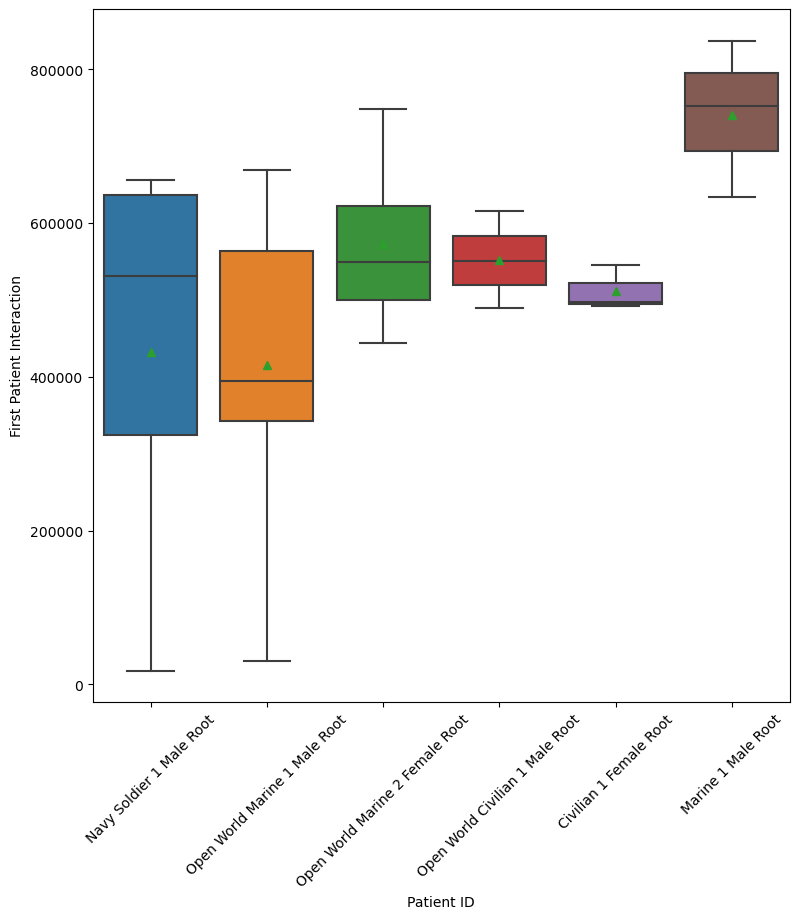

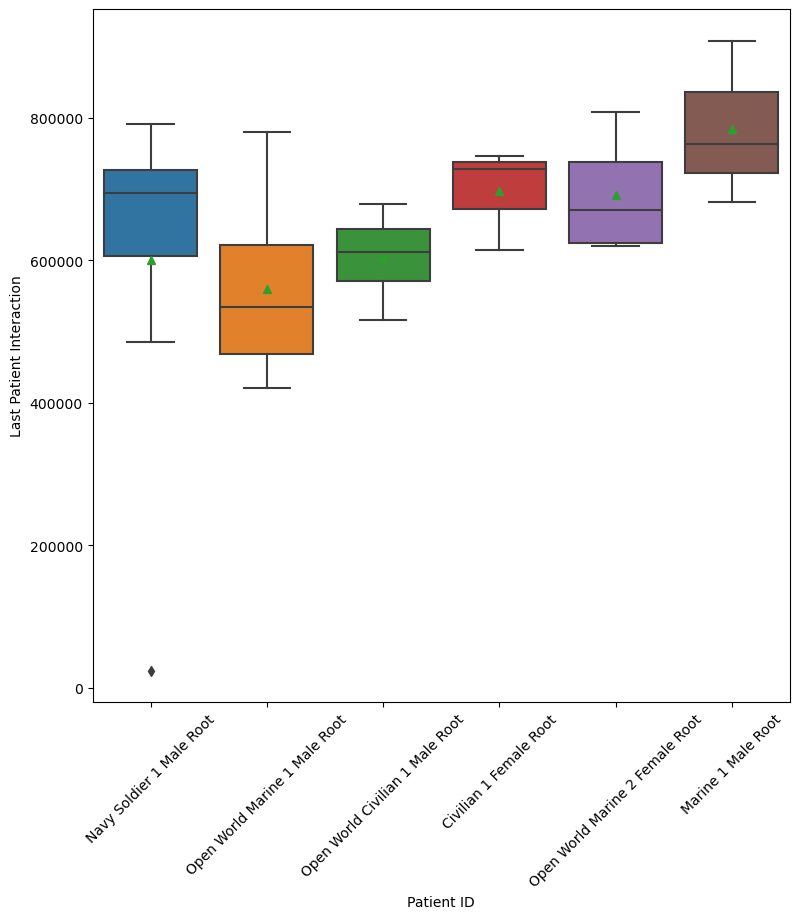

In [16]:

for cn in ['first_patient_interaction', 'last_patient_interaction']:
    mask_series = patient_stats_df.patient_id.isin(
        fu.desert_patients_list + fu.jungle_patients_list + fu.submarine_patients_list + fu.urban_patients_list
    )
    mask_series &= ~patient_stats_df[cn].isnull()
    if mask_series.any():
        transformable_df = patient_stats_df[mask_series].groupby(fu.scene_groupby_columns).min().reset_index(drop=False).sort_values(cn)
        fu.plot_grouped_box_and_whiskers(
            transformable_df,
            'patient_id',
            cn,
            'Patient ID',
            ' '.join([w.title() for w in cn.split('_')]),
            transformer_name=None,
            is_y_temporal=False,
        )


----

In [7]:

print()
is_scalar_lambda = lambda value: isinstance(value, (int, float, str, bool, np.number))
for (session_uuid, scene_id), scene_df in elevens_df.groupby(fu.scene_groupby_columns):
    scene_start = fu.get_scene_start(scene_df)
    for (encounter_layout, patient_id), patient_df in scene_df.groupby(['encounter_layout', 'patient_id']):
        mask_series = ~patient_df.injury_id.isnull()
        injury_id = patient_df[mask_series].injury_id.iloc[-1]
        if is_scalar_lambda(fu.get_is_correct_bleeding_tool_applied(patient_df)): print(
            "        row_dict['is_correct_bleeding_tool_applied'] = fu.get_is_correct_bleeding_tool_applied(patient_df)"
        )
        if is_scalar_lambda(fu.get_is_patient_dead(patient_df)): print(
            "        row_dict['is_patient_dead'] = fu.get_is_patient_dead(patient_df)"
        )
        if is_scalar_lambda(fu.get_is_patient_still(patient_df)): print(
            "        row_dict['is_patient_still'] = fu.get_is_patient_still(patient_df)"
        )
        if is_scalar_lambda(fu.get_max_salt(patient_df, random_patient_id=None)): print(
            "        row_dict['max_salt'] = fu.get_max_salt(patient_df, random_patient_id=None)"
        )
        if is_scalar_lambda(fu.get_last_tag(patient_df)): print(
            "        row_dict['last_tag'] = fu.get_last_tag(patient_df)"
        )
        if is_scalar_lambda(fu.get_patient_location(patient_df, action_tick=0)): print(
            "        row_dict['patient_location'] = fu.get_patient_location(patient_df, action_tick=0)"
        )
        if is_scalar_lambda(fu.get_is_tag_correct(patient_df)): print(
            "        row_dict['is_tag_correct'] = fu.get_is_tag_correct(patient_df)"
        )
        if is_scalar_lambda(fu.get_is_patient_severely_hemorrhaging(patient_df)): print(
            "        row_dict['is_patient_severely_hemorrhaging'] = fu.get_is_patient_severely_hemorrhaging(patient_df)"
        )
        if is_scalar_lambda(fu.get_first_patient_triage(patient_df)): print(
            "        row_dict['first_patient_triage'] = fu.get_first_patient_triage(patient_df)"
        )
        if is_scalar_lambda(fu.get_first_patient_interaction(patient_df)): print(
            "        row_dict['first_patient_interaction'] = fu.get_first_patient_interaction(patient_df)"
        )
        if is_scalar_lambda(fu.get_last_patient_interaction(patient_df)): print(
            "        row_dict['last_patient_interaction'] = fu.get_last_patient_interaction(patient_df)"
        )
        if is_scalar_lambda(fu.get_is_patient_gazed_at(patient_df)): print(
            "        row_dict['is_patient_gazed_at'] = fu.get_is_patient_gazed_at(patient_df)"
        )
        if is_scalar_lambda(fu.get_wanderings(patient_df)): print(
            "        row_dict['wanderings'] = fu.get_wanderings(patient_df)"
        )
        if is_scalar_lambda(fu.get_wrapped_label(patient_df, wrap_width=20)): print(
            "        row_dict['wrapped_label'] = fu.get_wrapped_label(patient_df, wrap_width=20)"
        )
        if is_scalar_lambda(fu.get_is_patient_hemorrhaging(patient_df)): print(
            "        row_dict['is_patient_hemorrhaging'] = fu.get_is_patient_hemorrhaging(patient_df)"
        )
        if is_scalar_lambda(fu.get_time_to_hemorrhage_control(patient_df, scene_start=scene_start)): print(
            "        row_dict['time_to_hemorrhage_control'] = fu.get_time_to_hemorrhage_control(patient_df, scene_start=scene_start)"
        )
        if is_scalar_lambda(fu.get_patient_engagement_count(patient_df)): print(
            "        row_dict['patient_engagement_count'] = fu.get_patient_engagement_count(patient_df)"
        )
        if is_scalar_lambda(fu.get_maximum_injury_severity(patient_df)): print(
            "        row_dict['maximum_injury_severity'] = fu.get_maximum_injury_severity(patient_df)"
        )
        if is_scalar_lambda(fu.get_is_life_threatened(patient_df)): print(
            "        row_dict['is_life_threatened'] = fu.get_is_life_threatened(patient_df)"
        )
        if is_scalar_lambda(fu.get_treatment_value(patient_df, injury_id)): print(
            "        row_dict['treatment_value'] = fu.get_treatment_value(patient_df, injury_id)"
        )
        if is_scalar_lambda(fu.get_tag_value(patient_df)): print(
            "        row_dict['tag_value'] = fu.get_tag_value(patient_df)"
        )
        if is_scalar_lambda(fu.get_pulse_value(patient_df)): print(
            "        row_dict['pulse_value'] = fu.get_pulse_value(patient_df)"
        )
        break
    break


        row_dict['is_correct_bleeding_tool_applied'] = fu.get_is_correct_bleeding_tool_applied(patient_df)
        row_dict['is_patient_dead'] = fu.get_is_patient_dead(patient_df)
        row_dict['is_patient_still'] = fu.get_is_patient_still(patient_df)
        row_dict['max_salt'] = fu.get_max_salt(patient_df, random_patient_id=None)
        row_dict['last_tag'] = fu.get_last_tag(patient_df)
        row_dict['is_tag_correct'] = fu.get_is_tag_correct(patient_df)
        row_dict['is_patient_severely_hemorrhaging'] = fu.get_is_patient_severely_hemorrhaging(patient_df)
        row_dict['first_patient_triage'] = fu.get_first_patient_triage(patient_df)
        row_dict['first_patient_interaction'] = fu.get_first_patient_interaction(patient_df)
        row_dict['last_patient_interaction'] = fu.get_last_patient_interaction(patient_df)
        row_dict['is_patient_gazed_at'] = fu.get_is_patient_gazed_at(patient_df)
        row_dict['wrapped_label'] = fu.get_wrapped_label(patient_df, wrap_wi

In [4]:

logs_columns_set = set(logs_df.columns)
file_columns_set = set(json_stats_df.columns)
scene_columns_set = set(scene_stats_df.columns)

In [5]:

sorted(logs_columns_set.intersection(file_columns_set))

['participant_id', 'session_uuid']

In [6]:

sorted(logs_columns_set.intersection(scene_columns_set))

['participant_id', 'scene_id', 'session_uuid']

In [7]:

sorted(file_columns_set.intersection(scene_columns_set))

['participant_id', 'session_uuid']